In [1]:
import numpy as np
import pandas as pd
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from glob import glob

## 9つの視点から撮影したデータをロード

In [2]:
vp_type = "*"  # Viewpoint type

pict_dir = "../_ignored/data/push-ups_2017-12-05/{}/pict/2-1.COCO-pose/".format(vp_type)
for f in glob(pict_dir):
    print(f)

print()    

movie_dir = "../_ignored/data/push-ups_2017-12-05/{}/movie/2-1.COCO-pose/".format(vp_type)
for f in glob(movie_dir):
    print(f)
    
print()
misc_pict_dir = ["../_ignored/data/pict_push-ups-from-side/2-1.COCO-pose/0_up.csv", \
                 "../_ignored/data/pict_push-ups-from-side/2-1.COCO-pose/1_down.csv"]
misc_movie_dir = "../_ignored/data/movie_push-ups-from-side/2-1.COCO-pose_mod/"

data_files = glob(pict_dir + "*.csv") + glob(movie_dir + "*.csv")
misc_data_files = misc_pict_dir + glob(misc_movie_dir + "*.csv")
[print(f) for f in misc_data_files]

../_ignored/data/push-ups_2017-12-05/lower_side/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/lower_front/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_naname/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/upper_naname/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_side/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/upper_front/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_front/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/upper_side/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/lower_naname/pict/2-1.COCO-pose/

../_ignored/data/push-ups_2017-12-05/lower_side/movie/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/lower_front/movie/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_naname/movie/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/upper_naname/movie/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_side/movie/2-1.COCO-pose/
../_ignored/data/push-u

[None, None, None, None, None, None, None, None]

In [3]:
def loadCSV(file):
    df = pd.read_csv(file, header=None, dtype=str)
    return df.values

def fillNan(file):
    df = pd.read_csv(file, header=None, dtype=str)
    idx = np.arange(55)
    idx[0], idx[-1] = 54, 0
    df[df.isnull().any(axis=1)] = df[df.isnull().any(axis=1)].iloc[:, idx]
    df = df.replace(np.nan, "0")
    return df.values

def loadAllData(csv_list, vs, hs, stats = ["_up", "_down", "movie"]):
    out = [{} for _ in range(2*len(stats))]
    
    for v in vs:
        for h in hs:
            pos = v + "_" + h
            filtered_csv_list = list(filter(lambda x: pos in x, csv_list))
            # print(filtered_csv_list)
            for i, s in enumerate(stats):
                arrays = [fillNan(f) for f in filtered_csv_list if s in f]
                if len(arrays) > 0:
                    tmp = np.vstack(arrays)
                    out[2*i][pos] = tmp[:, :-1].astype(float)
                    out[2*i + 1][pos] = tmp[:, -1].astype(str)
                else:
                    out[2*i][pos] = None
                    out[2*i + 1][pos] = None
#                 out[i][pos] = tmp
    return out
                
def loadMiscData(csv_list):
    stats = ["_up", "_down", "movie"]
    out = []
    for s in stats:
        arrays = [fillNan(f) for f in csv_list if s in f]
        if len(arrays) > 0:
            tmp = np.vstack(arrays)
            out.append(tmp[:, :-1].astype(float))
            out.append(tmp[:, -1].astype(str))
    return out
    
# def loadData(stat, pict, movie):
#     def getIntgData(which, dirs):
#         _dir = filter(lambda x: which in x, dirs)
#         out = np.vstack([loadCSV(d) for s in stat for d in _dir if s in d])
#         return out
#     up_data = getIntgData("_up", pict)
#     down_data = getIntgData("_down", pict)
#     movie_data = getIntgData("movie", movie)
#     return up_data, down_data, movie_data

In [4]:
v_stat = ["lower", "middle", "upper"]
h_stat = ["side", "naname", "front"]

In [5]:
up_data, up_names, down_data, down_names, movie_data, movie_names = loadAllData(data_files, v_stat, h_stat)
up_data1, up_names1, down_data1, down_names1, movie_data1, movie_names1 = loadMiscData(data_files)

for pos in ["up", "down", "movie"]:
    for typ in ["data", "names"]:
        exec("{0}_{1}['misc'] = {0}_{1}1".format(pos, typ))

In [6]:
up_data.keys()

dict_keys(['lower_side', 'lower_naname', 'lower_front', 'middle_side', 'middle_naname', 'middle_front', 'upper_side', 'upper_naname', 'upper_front', 'misc'])

In [7]:
def chooseRL(data):
    '''
    data: data_num x 54
    '''
    if data is None:
        return np.zeros((1, 6))
        
    right = np.arange(2, 5)
    left = np.arange(5, 8)
    _data = data.reshape(-1, 18, 3)
    conf_r = _data[:, right, 2]  # n_data x 3
    conf_l = _data[:, left, 2]   # n_data x 3
    
    def isZeroInRow(tmp):
        # tmp: n_data x n_joint
        return np.any(tmp == 0, axis=1)

    right_bool, left_bool = np.zeros(18, dtype=bool), np.zeros(18, dtype=bool)
    right_bool[right] = True
    left_bool[left] = True
    rl_bool = (left_bool, right_bool)
    
    conf_0 = np.logical_xor(isZeroInRow(conf_r), isZeroInRow(conf_l))    # inclusion of zero for r&l matches
    conf_nonzero = isZeroInRow(conf_r) > isZeroInRow(conf_l)
    conf_val = (np.mean(conf_r, axis=1) > np.mean(conf_l, axis=1))  # mean conf for r is larger than l
    mask = np.zeros(_data.shape[:2], dtype=bool)
    # 左右どちらもconf=0の関節がある場合、どうせそのデータは削除されるので適当に選ぶ
    # 左右どちらもconf=0の関節がない場合、平均confが大きい方を選ぶ
    # これらはまとめて処理できる
    for i in range(data.shape[0]):
        if conf_0[i]:
            mask[i] = rl_bool[conf_val[i]]
        else:
            mask[i] = rl_bool[conf_nonzero[i]]

    pos = _data[mask, :2]
    out = pos.reshape(-1, 6)
    return out

def extractJointPos(data, index_list):
    return np.dstack([data[:, index_list*3], data[:, index_list*3+1]]).reshape(-1, 2*len(index_list))

def extractJointConf(data, index_list):
    return data[:, index_list*3+2]

# def normalizePos(pos, all_data):
#     '''
#     Assuming...
#     pos: n_data x (2*n_selected_joint); x, y, ...
#     all_data: n_data x (3*n_all_joint); x, y, conf, ...
#     '''
#     if all_data is None:
#         return np.zeros_like(pos)
#     N, d = pos.shape
#     N, D = all_data.shape
#     pos = pos.reshape(N, d//2, 2)
#     all_data = all_data.reshape(N, D//3, 3)[:, :, 0:2]
#     xy_max = np.max(all_data, axis=1)[:, np.newaxis]
#     xy_min = np.min(all_data, axis=1)[:, np.newaxis]
#     out = (pos - xy_min)/(xy_max - xy_min)
#     return out.reshape(N, d)

def normalizePos(pos, all_data):
    '''
    Assuming...
    pos: n_data x (2*n_selected_joint); x, y, ...
    all_data: n_data x (3*n_all_joint); x, y, conf, ...
    '''
    if all_data is None:
        return np.zeros_like(pos)
    rows, cols = pos.shape
    all_rows, all_cols = all_data.shape
    if all_cols % 3 != 0:
        print("all_data needs 3*n cols")
        return
    x = all_data[:, range(0, 54, 3)]
    y = all_data[:, range(1, 54, 3)]
    conf = all_data[:, range(2, 54, 3)]
    
    x_max = np.max(x, axis=1, keepdims=True)
    x[conf < 0.05] = np.inf
    x_min = np.min(x, axis=1, keepdims=True)
    
    y_max = np.max(y, axis=1, keepdims=True)
    y[conf < 0.05] = np.inf
    y_min = np.min(y, axis=1, keepdims=True)
    
    pos_max = np.tile(np.reshape(np.dstack([x_max, y_max]), (-1, 2)), (1, cols//2))
    pos_min = np.tile(np.reshape(np.dstack([x_min, y_min]), (-1, 2)), (1, cols//2))
    
    # return pos / (pos_max - pos_min)
    return (pos - pos_min)/(pos_max - pos_min)

def getMaskForLowConf(pos):
    N, d = pos.shape
    mask = np.ones(N, dtype=bool)
    mask[np.any(pos == 0., axis=1)] = False
    return mask

def deleteLowConf(pos, data):
    '''
    data: data_num x (2*joint_num)
    '''
    mask = getMaskForLowConf(pos)
    return pos[mask], data[mask], mask

def makeFeature(pos):
    n, d = pos.shape
    d //= 2
    _pos = pos.reshape(n, d, 2)
    # カーネル行列を作る時に使うテクニックのテンソル版
    a = np.repeat(np.sum(_pos**2, axis=2)[:, :, np.newaxis], d, axis=2)
    b = np.transpose(a, (0, 2, 1))
    c = np.einsum("ijk,ilk->ijl", _pos, _pos)
    out = a - 2*c + b
    i1, i2 = np.triu_indices(d, k=1)
    out = out[np.repeat(np.arange(n), [d*(d-1)//2]), np.tile(i1, n), np.tile(i2, n)].reshape(n, d*(d-1)//2)
    return out

def mapdict(dic, func):
    if type(dic) == dict:
        return {k:func(v) for (k, v) in dic.items()}
    elif type(dic) in [list, tuple]:
        keys = dic[0].keys()
        return {k:func(*list(map(lambda x: x.get(k), dic))) for k in keys}

In [8]:
up_pos = mapdict(up_data, chooseRL)
up_mask = mapdict(up_pos, getMaskForLowConf)
down_pos = mapdict(down_data, chooseRL)
down_mask = mapdict(down_pos, getMaskForLowConf)
movie_pos = mapdict(movie_data, chooseRL)
movie_mask = mapdict(movie_pos, getMaskForLowConf)

In [9]:
nm_up_pos = mapdict([up_pos, up_data], normalizePos)
nm_down_pos = mapdict([down_pos, down_data], normalizePos)
nm_movie_pos = mapdict([movie_pos, movie_data], normalizePos)

/Users/kentaro_abe/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


In [10]:
# 距離を特徴量にする
nm_up_pos = mapdict(nm_up_pos, makeFeature)
nm_down_pos = mapdict(nm_down_pos, makeFeature)
nm_movie_pos = mapdict(nm_movie_pos, makeFeature)

In [11]:
train_key = ["{}_{}".format(a, b) for a in ["upper", "middle", "lower"] for b in ["side", "naname", "front"]] + ["misc"]

In [12]:
def makeTrainData():
    train_key = ["{}_{}".format(a, b) for a in ["upper", "middle", "lower"] for b in ["side", "naname", "front"]] + ["misc"]
    train_nm_up_pos = np.vstack([nm_up_pos[k] for k in train_key])
    train_nm_down_pos = np.vstack([nm_down_pos[k] for k in train_key])
    train_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in train_key])
    train_nm_up_mask = np.hstack([up_mask[k] for k in train_key])
    train_nm_down_mask = np.hstack([down_mask[k] for k in train_key])
    train_nm_movie_mask = np.hstack([movie_mask[k] for k in train_key])
    
    train_data = np.vstack([train_nm_up_pos, train_nm_down_pos])#, train_nm_movie_pos])
    train_mask = np.hstack([train_nm_up_mask, train_nm_down_mask])#, train_nm_movie_mask])
    
    labels = np.hstack([
        1 * np.ones(train_nm_up_pos.shape[0], dtype=int),
        0 * np.ones(train_nm_down_pos.shape[0], dtype=int)#,
        #-1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
    ])
    
    return train_data, train_mask, labels

def makeTestData(a, b):
    test_key = ["{}_{}".format(a, b)]
#   test_key = ["misc"]
    
    test_nm_up_pos = np.vstack([nm_up_pos[k] for k in test_key])
    test_nm_down_pos = np.vstack([nm_down_pos[k] for k in test_key])
    test_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in test_key])

    
    test_nm_up_mask = np.hstack([up_mask[k] for k in test_key])
    test_nm_down_mask = np.hstack([down_mask[k] for k in test_key])
    test_nm_movie_mask = np.hstack([movie_mask[k] for k in test_key])

    
    test_data = test_nm_movie_pos[:len(test_nm_movie_pos)]
   
    test_mask = test_nm_movie_mask[:len(test_nm_movie_pos)]# np.hstack([test_nm_up_mask, test_nm_down_mask, test_nm_movie_mask])
    
    return test_data, test_mask

In [13]:
def train(train_data, train_mask, labels):
    clf = SVC()
    clf.fit(train_data[train_mask], labels[train_mask])
    return clf

def predict(clf, test_data):
    pred_label = clf.predict(test_data)
#         pred_proba = clf.predict_proba(test_data[test_mask])

    return pred_label

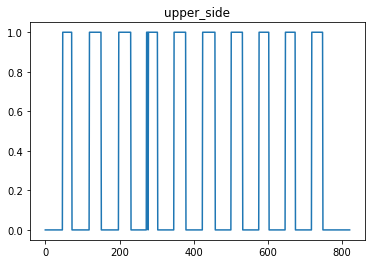

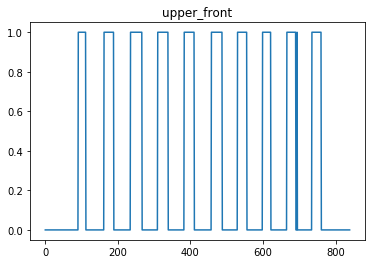

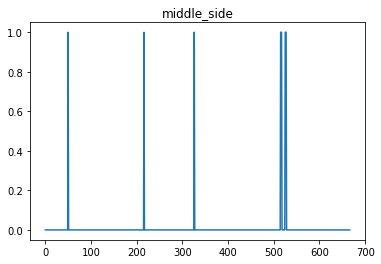

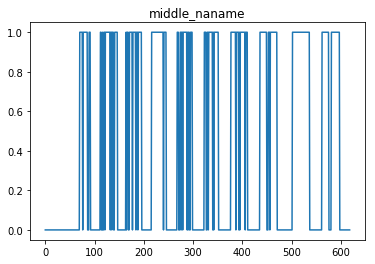

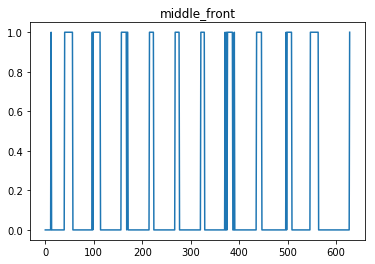

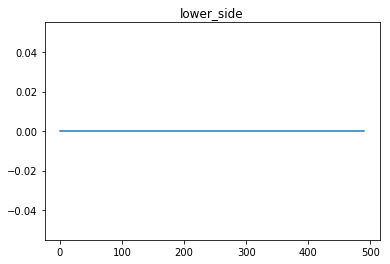

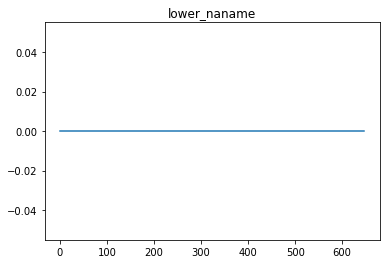

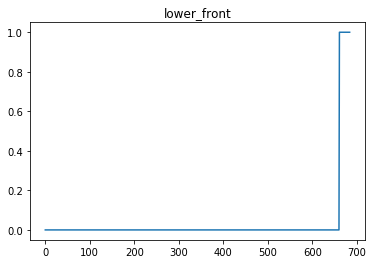

In [14]:
for i, a in enumerate(["upper", "middle", "lower"]):
    for j, b in enumerate(["side", "naname", "front"]):
        if a == "upper" and b == "naname":
            continue
        
        clf = train(*makeTrainData())
        test_data, test_mask = makeTestData(a, b)
        pred_label = predict(clf, test_data[test_mask])
        
        fig = plt.figure(3*i + j)
        plt.title("{}_{}".format(a, b))
        plt.plot(pred_label)
#         plt.plot(pred_proba[:, 1])
        plt.show()
        

# SVCのproba確認

(188,)


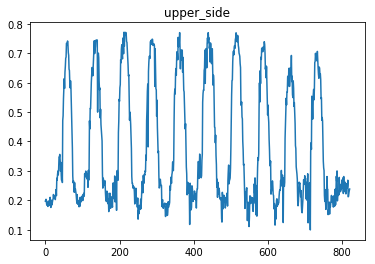

(188,)


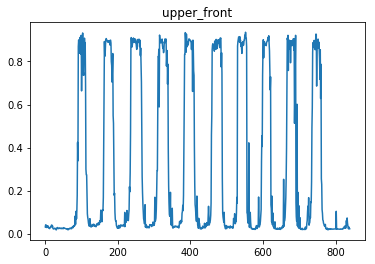

(188,)


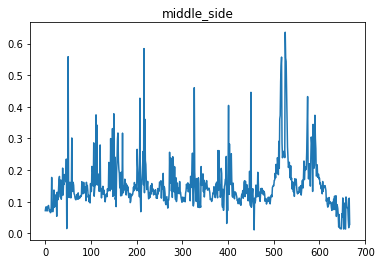

(188,)


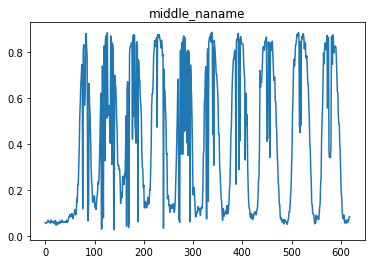

(188,)


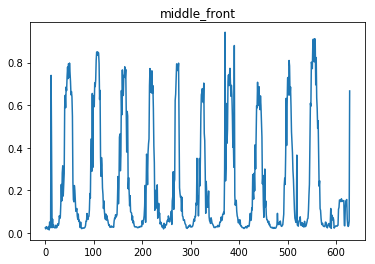

(188,)


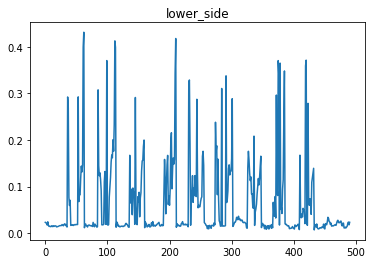

(188,)


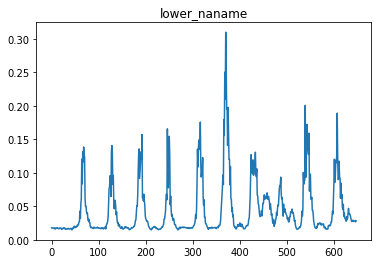

(188,)


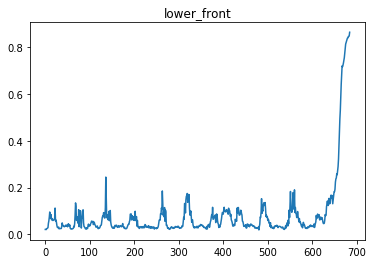

In [16]:
for i, a in enumerate(["upper", "middle", "lower"]):
    for j, b in enumerate(["side", "naname", "front"]):
        if a == "upper" and b == "naname":
            continue
        train_key = ["{}_{}".format(a, b) for a in ["upper", "middle", "lower"] for b in ["side", "naname", "front"]] + ["misc"]
        test_key = ["{}_{}".format(a, b)]
        
        if False:
            for tk in test_key:
                del train_key[train_key.index(tk)]
        
        train_nm_up_pos = np.vstack([nm_up_pos[k] for k in train_key])
        train_nm_down_pos = np.vstack([nm_down_pos[k] for k in train_key])
        train_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in train_key])
        test_nm_up_pos = np.vstack([nm_up_pos[k] for k in test_key])
        test_nm_down_pos = np.vstack([nm_down_pos[k] for k in test_key])
        test_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in test_key])
        
        train_nm_up_mask = np.hstack([up_mask[k] for k in train_key])
        train_nm_down_mask = np.hstack([down_mask[k] for k in train_key])
        train_nm_movie_mask = np.hstack([movie_mask[k] for k in train_key])
        test_nm_up_mask = np.hstack([up_mask[k] for k in test_key])
        test_nm_down_mask = np.hstack([down_mask[k] for k in test_key])
        test_nm_movie_mask = np.hstack([movie_mask[k] for k in test_key])
        
        train_data = np.vstack([train_nm_up_pos, train_nm_down_pos])#, train_nm_movie_pos])
        test_data = test_nm_movie_pos
        train_mask = np.hstack([train_nm_up_mask, train_nm_down_mask])#, train_nm_movie_mask])
        test_mask = test_nm_movie_mask# np.hstack([test_nm_up_mask, test_nm_down_mask, test_nm_movie_mask])
        
        labels = np.hstack([
            1 * np.ones(train_nm_up_pos.shape[0], dtype=int),
            0 * np.ones(train_nm_down_pos.shape[0], dtype=int)#,
            #-1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
        ])
        print(labels.shape)
        
        clf = SVC(probability=True)
#         clf = LabelSpreading()
        clf.fit(train_data[train_mask], labels[train_mask])
        
#         pred_label = clf.predict(test_data[test_mask])
        pred_proba = clf.predict_proba(test_data[test_mask])
        
        fig = plt.figure(3*i + j)
        plt.title(test_key[0])
#         plt.plot(pred_label)
        plt.plot(pred_proba[:, 1])
#         plt.plot([0, 800], [0.45]*2)
        plt.show()
        

# SVC.predict_probaとLabelSpreading.predict_probaの比較

(94,)


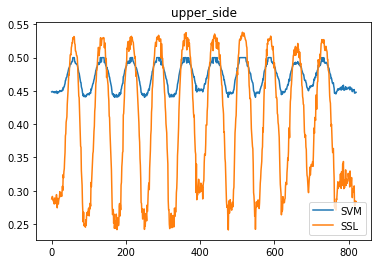

(94,)


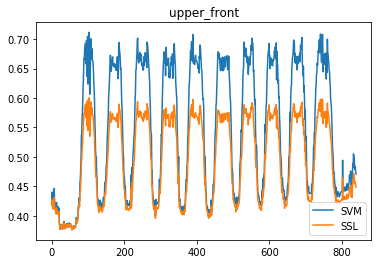

(94,)


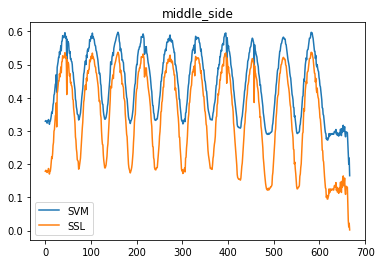

(94,)


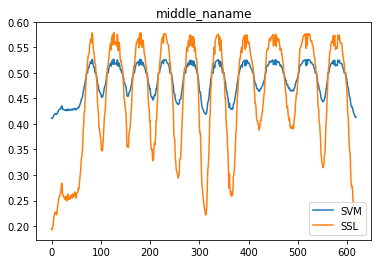

(94,)


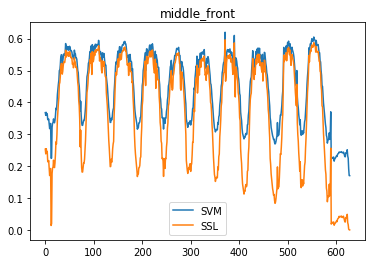

(94,)


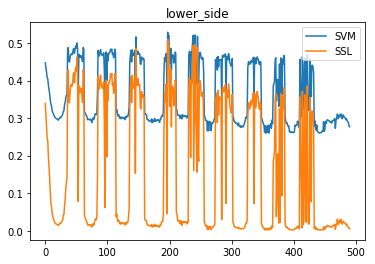

(94,)


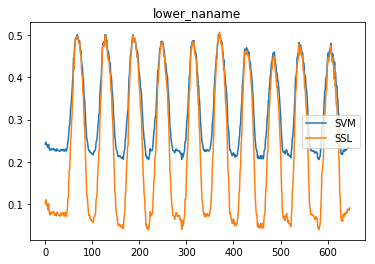

(94,)


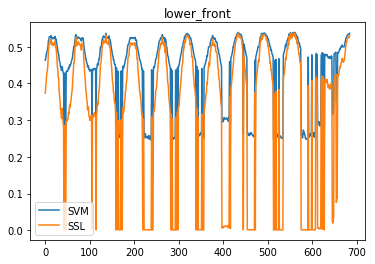

In [41]:
for i, a in enumerate(["upper", "middle", "lower"]):
    for j, b in enumerate(["side", "naname", "front"]):
        if a == "upper" and b == "naname":
            continue
        train_key = ["{}_{}".format(a, b) for a in ["upper", "middle", "lower"] for b in ["side", "naname", "front"]]
        test_key = ["{}_{}".format(a, b)]
        
        if False:
            for tk in test_key:
                del train_key[train_key.index(tk)]
        
        train_nm_up_pos = np.vstack([nm_up_pos[k] for k in train_key])
        train_nm_down_pos = np.vstack([nm_down_pos[k] for k in train_key])
        train_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in train_key])
        test_nm_up_pos = np.vstack([nm_up_pos[k] for k in test_key])
        test_nm_down_pos = np.vstack([nm_down_pos[k] for k in test_key])
        test_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in test_key])
        
        train_nm_up_mask = np.hstack([up_mask[k] for k in train_key])
        train_nm_down_mask = np.hstack([down_mask[k] for k in train_key])
        train_nm_movie_mask = np.hstack([movie_mask[k] for k in train_key])
        test_nm_up_mask = np.hstack([up_mask[k] for k in test_key])
        test_nm_down_mask = np.hstack([down_mask[k] for k in test_key])
        test_nm_movie_mask = np.hstack([movie_mask[k] for k in test_key])
        
        train_data = np.vstack([train_nm_up_pos, train_nm_down_pos])#, train_nm_movie_pos])
        test_data = test_nm_movie_pos
        train_mask = np.hstack([train_nm_up_mask, train_nm_down_mask])#, train_nm_movie_mask])
        test_mask = test_nm_movie_mask# np.hstack([test_nm_up_mask, test_nm_down_mask, test_nm_movie_mask])
        
        labels = np.hstack([
            1 * np.ones(train_nm_up_pos.shape[0], dtype=int),
            0 * np.ones(train_nm_down_pos.shape[0], dtype=int)#,
            #-1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
        ])
        print(labels.shape)
        
        clf = SVC(probability=True)
        clf2 = LabelSpreading()
        clf.fit(train_data[train_mask], labels[train_mask])
        clf2.fit(train_data[train_mask], labels[train_mask])
        
        pred_label = clf.predict(test_data[test_mask])
        pred_proba = clf.predict_proba(test_data[test_mask])
        pred_label2 = clf2.predict(test_data[test_mask])
        pred_proba2 = clf2.predict_proba(test_data[test_mask])
        
        fig = plt.figure(3*i + j)
        plt.title(test_key[0])
        plt.plot(pred_proba[:, 1], label="SVM")
        plt.plot(pred_proba2[:, 1], label="SSL")
        plt.legend(loc="best")
        plt.show()
        

## predict_proba

In [32]:
clf = LabelSpreading()
clf.fit(train_data[train_mask], labels[train_mask])

pred_label = clf.predict(test_data[test_mask])
pred_proba = clf.predict_proba(test_data[test_mask])

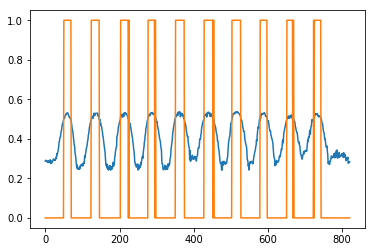

In [33]:
plt.plot(pred_proba[:, 1])
plt.plot(pred_label)
plt.show()

## Openposeにupper_frontとupper_sideの動画をやらせた結果

upper_front

In [62]:
output_test_data = []
with open("output_feature.txt") as f:
    for line in f.readlines():
        datum = np.array(line.strip().split(" ")).astype(float)
        output_test_data.append(datum)
output_test_data = np.array(output_test_data)

output_pos_data = []
with open("output2.txt") as f:
    for line in f.readlines():
        datum = np.array(line.strip().split(" ")).astype(float)
        output_pos_data.append(datum)
output_pos_data = np.array(output_pos_data)
output_maxmin = output_pos_data[:, 54:]
output_pos_data = output_pos_data[:, :54]

In [63]:
output_pos_data

array([[  8.42315000e+02,   4.92007000e+02,   8.52436000e-01, ...,
          9.33528000e+02,   3.94907000e+02,   3.62838000e-01],
       [  8.39383000e+02,   4.89031000e+02,   8.77304000e-01, ...,
          9.30587000e+02,   3.88911000e+02,   5.19287000e-01],
       [  8.39347000e+02,   4.86133000e+02,   8.97355000e-01, ...,
          9.30583000e+02,   3.89131000e+02,   5.16117000e-01],
       ..., 
       [  9.92329000e+02,   5.68534000e+02,   8.60329000e-01, ...,
          1.04834000e+03,   4.56774000e+02,   3.67437000e-01],
       [  9.80583000e+02,   5.71442000e+02,   9.09512000e-01, ...,
          1.04530000e+03,   4.59732000e+02,   3.12521000e-01],
       [  9.74745000e+02,   5.71531000e+02,   9.13864000e-01, ...,
          1.03069000e+03,   4.59679000e+02,   4.48615000e-01]])

In [64]:
movie_data["upper_front"].shape

(868, 54)

In [65]:
np.max(np.abs(output_pos_data.reshape(-1, 18, 3)[:, :, 1] - movie_data["upper_front"].reshape(-1, 18, 3)[:, :, 1][:-1]))

971.774

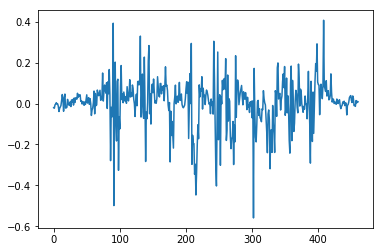

In [66]:
bodyPart = 0
xyscore = 2

tmp1 = output_pos_data.reshape(-1, 18, 3)[:, bodyPart, xyscore]
tmp2 = movie_data["upper_front"][1:].reshape(-1, 18, 3)[:, bodyPart, xyscore]
tmp3 = (tmp1 - tmp2)[np.logical_not(np.logical_or(tmp1 == 0, tmp2 == 0))]
# plt.plot(tmp1, label="abe")
# plt.plot(tmp2, label="htym")
# plt.plot(tmp1 - tmp2)
plt.plot(tmp3)
plt.legend(loc="best")
plt.show()

In [72]:
output_test_data

array([[ 0.265226,  1.02469 ,  0.248736],
       [ 0.253258,  1.02443 ,  0.260668],
       [ 0.249513,  1.00841 ,  0.256398],
       ..., 
       [ 0.23087 ,  1.02727 ,  0.28415 ],
       [ 0.236706,  0.926833,  0.226921],
       [ 0.223029,  1.04886 ,  0.304595]])

In [73]:
makeTestData("upper", "front")[0]

array([[ 0.20775092,  0.94303207,  0.26586467],
       [ 0.18448358,  0.89931379,  0.26968954],
       [ 0.18546396,  0.90124238,  0.26955859],
       ..., 
       [ 0.20580558,  0.95464306,  0.27402073],
       [ 0.2260433 ,  1.03062238,  0.29150605],
       [ 0.22355896,  1.03637029,  0.29736728]])

In [69]:
output_pos = chooseRL(output_pos_data)
output_mask = getMaskForLowConf(output_pos)
nm_output_pos = normalizePos(output_pos, output_pos_data)
nm_output_pos = makeFeature(nm_output_pos)

In [74]:
clf = train(*makeTrainData())
# pred_label = predict(clf, nm_output_pos[output_mask])
pred_label = predict(clf, output_test_data)

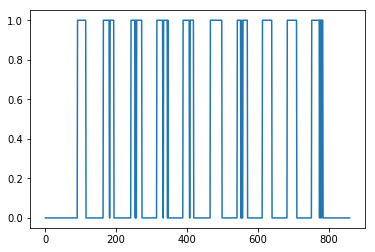

In [75]:
plt.plot(pred_label)
plt.show()

In [53]:
output_maxmin

array([[ 1089.42 ,   621.534,   756.948,   388.928],
       [ 1089.44 ,   621.541,   759.88 ,   388.911],
       [ 1089.48 ,   621.586,   762.818,   388.937],
       ..., 
       [ 1204.22 ,   759.84 ,   806.898,   456.667],
       [ 1204.33 ,   739.144,   806.859,   459.62 ],
       [ 1204.23 ,   768.685,   806.968,   453.755]])